In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

In [ ]:
numpy_saved_dir_path = "/content/drive/MyDrive/Gem Classification - Research/image_based_transfer_learning/numpy"

train_X = np.load(os.path.join(numpy_saved_dir_path, "train_X_no_rescale.npy"))
test_X = np.load(os.path.join(numpy_saved_dir_path, "test_X_no_rescale.npy"))
train_y = np.load(os.path.join(numpy_saved_dir_path, "train_y_no_rescale.npy"))
test_y = np.load(os.path.join(numpy_saved_dir_path, "test_y_no_rescale.npy"))

In [ ]:
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(731, 224, 224, 3) (731, 8)
(82, 224, 224, 3) (82, 8)


In [ ]:
base_model = keras.applications.MobileNetV3Large (
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
    include_preprocessing=True
)

In [ ]:
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(8)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()]
)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 7, 7, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 960)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 8)                 7688      
                                                                 
Total params: 3,004,040
Trainable params: 7,688
Non-trainable params: 2,996,352
_________________________________________________________________


In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2
)

In [ ]:
model_save_dir_path = "/content/drive/MyDrive/Gem Classification - Research/image_based_transfer_learning/models/MobileNetV3Large"

best_loss_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_save_dir_path, "MobileNetV3Large_include_preprocessing-best_loss_model.h5"),
    monitor="loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

best_val_loss_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_save_dir_path, "MobileNetV3Large_include_preprocessing-best_val_loss_model.h5"),
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

In [ ]:
bs = 32

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=bs, shuffle=True),
    steps_per_epoch=train_X.shape[0] // bs,
    epochs=10,
    validation_data=(test_X, test_y),
    validation_steps=test_X.shape[0],
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint],
    verbose=1
)

Epoch 1/10
22/22 [==============================] - 25s 999ms/step - loss: 1.6828 - categorical_accuracy: 0.3777 - val_loss: 0.9335 - val_categorical_accuracy: 0.6220
Epoch 2/10
22/22 [==============================] - 22s 1s/step - loss: 0.7689 - categorical_accuracy: 0.7668 - val_loss: 0.6565 - val_categorical_accuracy: 0.7683
Epoch 3/10
22/22 [==============================] - 22s 983ms/step - loss: 0.5548 - categorical_accuracy: 0.8469 - val_loss: 0.5207 - val_categorical_accuracy: 0.8659
Epoch 4/10
22/22 [==============================] - 22s 1s/step - loss: 0.4298 - categorical_accuracy: 0.8698 - val_loss: 0.4447 - val_categorical_accuracy: 0.8902
Epoch 5/10
22/22 [==============================] - 21s 963ms/step - loss: 0.3482 - categorical_accuracy: 0.9084 - val_loss: 0.4055 - val_categorical_accuracy: 0.9024
Epoch 6/10
22/22 [==============================] - 22s 990ms/step - loss: 0.3050 - categorical_accuracy: 0.9142 - val_loss: 0.3488 - val_categorical_accuracy: 0.9024
Epoc

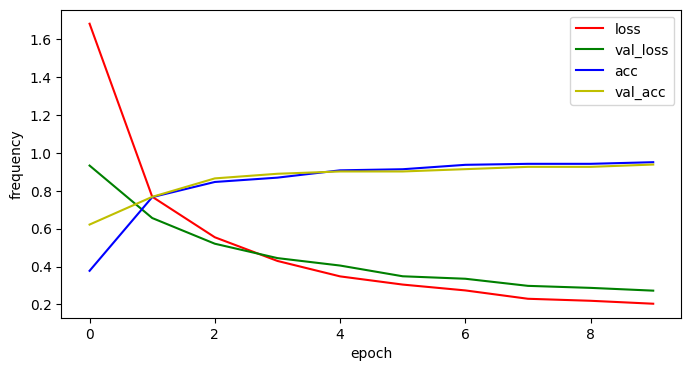

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], 'r-', label='loss')
plt.plot(history.history['val_loss'], 'g-', label='val_loss')
plt.plot(history.history['categorical_accuracy'], 'b-', label='acc')
plt.plot(history.history['val_categorical_accuracy'], 'y-', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [ ]:
val_loss_early_stopping = keras.callbacks.EarlyStopping (
    monitor="val_loss",
    mode="min",
    patience=5
)

In [ ]:
model.load_weights(os.path.join(model_save_dir_path, "MobileNetV3Large_include_preprocessing-best_val_loss_model.h5"))
loss, acc = model.evaluate(test_X, test_y)

3/3 [==============================] - 3s 683ms/step - loss: 0.2729 - categorical_accuracy: 0.9390


In [ ]:
bs = 32

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=bs, shuffle=True),
    steps_per_epoch=train_X.shape[0] // bs,
    epochs=100,
    validation_data=(test_X, test_y),
    validation_steps=test_X.shape[0],
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint, val_loss_early_stopping],
    verbose=1
)

Epoch 1/100
22/22 [==============================] - 23s 1s/step - loss: 0.1910 - categorical_accuracy: 0.9542 - val_loss: 0.2598 - val_categorical_accuracy: 0.9268
Epoch 2/100
22/22 [==============================] - 22s 989ms/step - loss: 0.1679 - categorical_accuracy: 0.9628 - val_loss: 0.2644 - val_categorical_accuracy: 0.9512
Epoch 3/100
22/22 [==============================] - 23s 1s/step - loss: 0.1477 - categorical_accuracy: 0.9614 - val_loss: 0.2362 - val_categorical_accuracy: 0.9390
Epoch 4/100
22/22 [==============================] - 21s 953ms/step - loss: 0.1448 - categorical_accuracy: 0.9671 - val_loss: 0.2375 - val_categorical_accuracy: 0.9512
Epoch 5/100
22/22 [==============================] - 22s 1s/step - loss: 0.1440 - categorical_accuracy: 0.9642 - val_loss: 0.2172 - val_categorical_accuracy: 0.9390
Epoch 6/100
22/22 [==============================] - 22s 981ms/step - loss: 0.1335 - categorical_accuracy: 0.9742 - val_loss: 0.2110 - val_categorical_accuracy: 0.9268
E

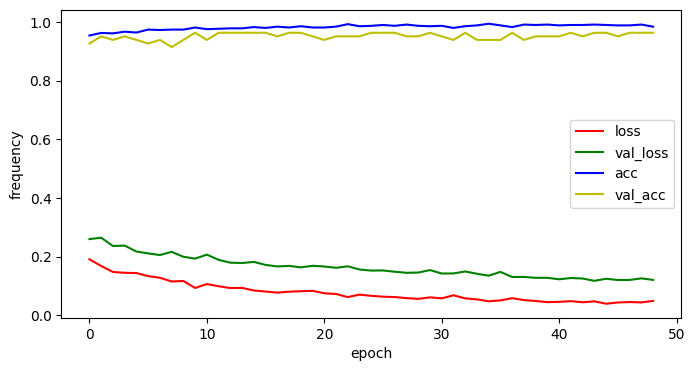

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], 'r-', label='loss')
plt.plot(history.history['val_loss'], 'g-', label='val_loss')
plt.plot(history.history['categorical_accuracy'], 'b-', label='acc')
plt.plot(history.history['val_categorical_accuracy'], 'y-', label='val_acc')
plt.xlabel('epoch')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [ ]:
model.load_weights(os.path.join(model_save_dir_path, "MobileNetV3Large_include_preprocessing-best_val_loss_model.h5"))
loss, acc = model.evaluate(test_X, test_y)

3/3 [==============================] - 1s 440ms/step - loss: 0.1173 - categorical_accuracy: 0.9634
